## Predicting Teacher Attrition Rates for Public Schools
**This notebook explores predicting teacher attrition rates for public schools in North Carolina.** 
* Public school racial compositions are also considered when making predictions in this notebook.
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/wtubin/TeacherRetentionofNC

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [2]:
#!pip install xgboost


In [3]:
#import required Libraries
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV    
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics as mt
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import cross_validate
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math




In [4]:
#The 'path' variable may also be a URL pointing to the proper raw file path on github: 

ML2017 = '../Machine Learning Datasets/PublicSchools2017_ML.csv'
ML2016 = '../../2016/Machine Learning Datasets/PublicSchools2016_ML.csv'
ML2015 =  '../../2015/Machine Learning Datasets/PublicSchools2015_ML.csv'
ML2014 =  '../../2014/Machine Learning Datasets/PublicSchools2014_ML.csv'

schData2017=pd.read_csv(ML2017, low_memory=False)
print('*********************************2017 ML Data*************************************')
schData2017.info()
schData2016=pd.read_csv(ML2016, low_memory=False)
print('*********************************2016 ML Data*************************************')
schData2016.info()

schData2015=pd.read_csv(ML2015, low_memory=False)
print('*********************************2015 ML Data*************************************')
schData2015.info()

schData2014=pd.read_csv(ML2014, low_memory=False)
print('*********************************2014 ML Data*************************************')
schData2014.info()

*********************************2017 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 396 entries, student_num to unit_code
dtypes: float64(352), int64(44)
memory usage: 7.5 MB
*********************************2016 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Columns: 376 entries, closed_ind to unit_code
dtypes: float64(298), int64(78)
memory usage: 7.0 MB
*********************************2015 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Columns: 405 entries, closed_ind to unit_code
dtypes: float64(344), int64(61)
memory usage: 7.5 MB
*********************************2014 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Columns: 366 entries, closed_ind to unit_code
dtypes: float64(333), int64(

## Fix Year

In [5]:
schData2014["Year"]=2014
schData2015["Year"]=2015
schData2016["Year"]=2016
schData2017["Year"]=2017

In [6]:
# Combine the data sets
schData = pd.concat([schData2017,schData2016,schData2015,schData2014], axis=0, ignore_index=True, sort = True)

In [7]:
schData['Number of farm returns 75KLT100K'].describe()

count    9756.000000
mean       72.796228
std        63.113575
min         0.000000
25%        20.000000
50%        60.000000
75%       110.000000
max       240.000000
Name: Number of farm returns 75KLT100K, dtype: float64

In [8]:
#Missing Data Threshold (Per Column)
missingThreshold = 0.60

#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 25


#Eliminate continuous columns with more than missingThreshold percentage of missing values
schoolDataRecordCt = schData.shape[0]
missingValueLimit = schoolDataRecordCt * missingThreshold
NullValueCounts = schData.isnull().sum()
NullValueCols = NullValueCounts[NullValueCounts >= missingValueLimit].index
schData = schData.drop(NullValueCols, axis=1)

#Review dataset contents after empty field drops
print('*********After: Removing columns with >= missingThreshold % of missing values******')
schData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(NullValueCols))


*********After: Removing columns with >= missingThreshold % of missing values******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9756 entries, 0 to 9755
Columns: 412 entries, (TCE) prepared returns Ct 100KLT200K to wap_per_classroom
dtypes: float64(393), int64(19)
memory usage: 30.7 MB

Columns Deleted:  101


In [9]:
#Print out all the missing value rows
pd.set_option('display.max_rows', 1000)

print('\r\n*********The Remaining Missing Values Below will be set to Zero!*************************')

#Check for Missing values 
missing_values = schData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values



*********The Remaining Missing Values Below will be set to Zero!*************************


,Variable Name,Number Missing Values
0,(TCE) prepared returns Ct 100KLT200K,4858
1,(TCE) prepared returns Ct 25KLT50K,2426
2,(TCE) prepared returns Ct 75KLT100K,2426
3,(VITA) prepared returns Ct 100KLT200K,2426
4,(VITA) prepared returns Ct 25KLT50K,2426
5,(VITA) prepared returns Ct 50KLT75K,2426
7,00_Size,2426
8,01_Size,4894
9,02_Size,2426
10,03_Size,2426


In [10]:
#Replace all remaining NaN with 0
schData = schData.fillna(0)

#Check for Missing values after final imputation 
missing_values = schData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values

,Variable Name,Number Missing Values


### we are not remove the 0 1 year percentage for now.

In [11]:
zeroAttrition = schData[schData['_1yr_tchr_trnovr_pct']==0.0].index
schData = schData.drop(zeroAttrition,axis=0)
print('*********After: Removing rows with first year turn over percentage =0.00******')
schData.info(verbose=False)
print ('\r\nRows Deleted: ', len(zeroAttrition))

*********After: Removing rows with first year turn over percentage =0.00******
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9253 entries, 1 to 9755
Columns: 412 entries, (TCE) prepared returns Ct 100KLT200K to wap_per_classroom
dtypes: float64(393), int64(19)
memory usage: 29.2 MB

Rows Deleted:  503


## Visulization

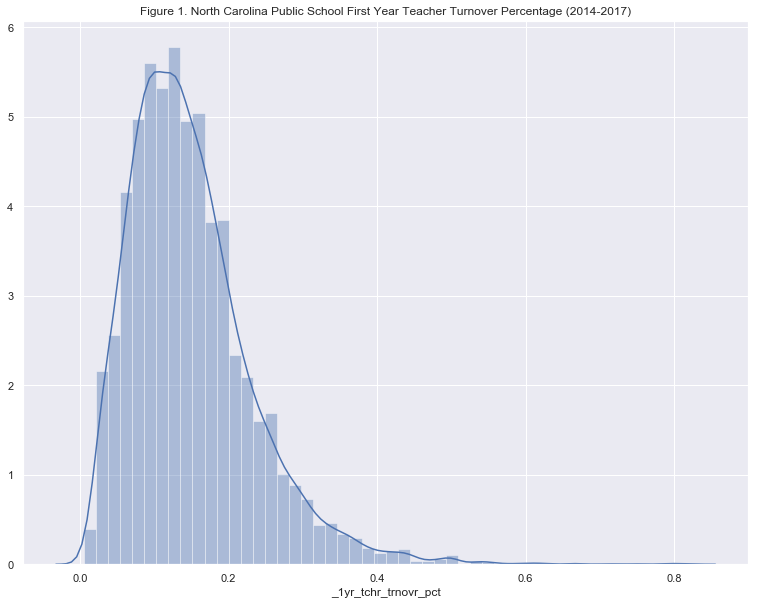

In [12]:
plt.figure(figsize=(13,10))
_1yr_tchr_trnovr_pct = schData["_1yr_tchr_trnovr_pct"]
ax = sns.distplot(_1yr_tchr_trnovr_pct);
plt.title("Figure 1. North Carolina Public School First Year Teacher Turnover Percentage (2014-2017)")
plt.show()

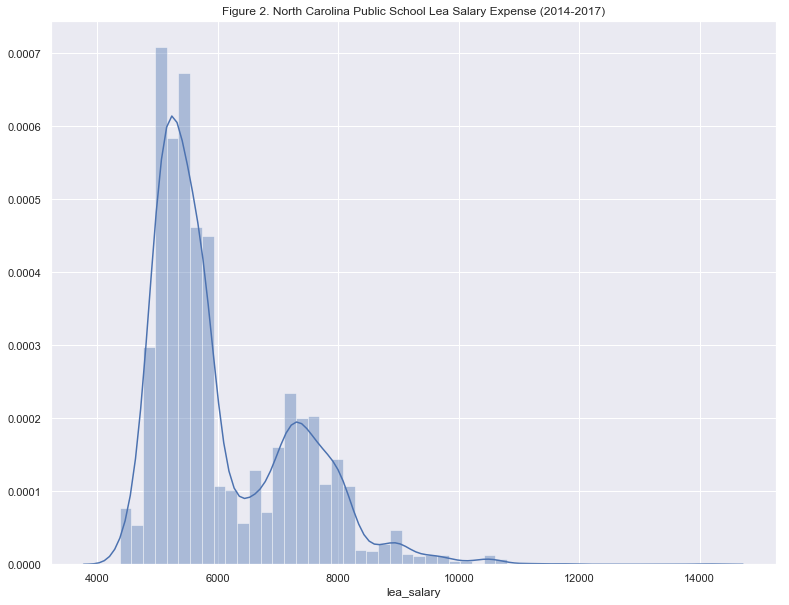

In [13]:
schData['lea_salary'] = schData['lea_total_expense_num']*schData['lea_salary_expense_pct']

plt.figure(figsize=(13,10))
lea_salary_expense_pct=schData.lea_salary_expense_pct
ax = sns.distplot(schData['lea_salary']);
plt.title("Figure 2. North Carolina Public School Lea Salary Expense (2014-2017)")
plt.show()

In [14]:
# responseible variabl distribution
schData['_1yr_tchr_trnovr_pct'].describe()

count    9253.000000
mean        0.148518
std         0.083152
min         0.005000
25%         0.090000
50%         0.135000
75%         0.189000
max         0.818000
Name: _1yr_tchr_trnovr_pct, dtype: float64

## we may want to check the outliers

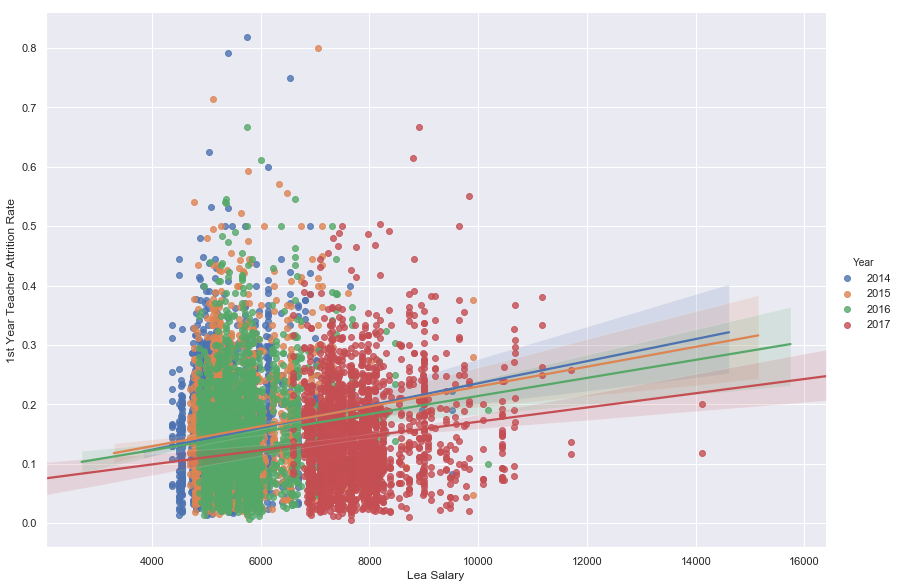

In [26]:
sns.set_style("darkgrid")
data = schData
sns.lmplot(x="lea_salary", y="_1yr_tchr_trnovr_pct", hue = "Year",  data=data,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 3. North Carolina Public School One Year Teacher Attrition Rate vs. LEA Salary Expenditure (2014-2017)")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Lea Salary')
#plt.show()
plt.savefig('Figure1.png')

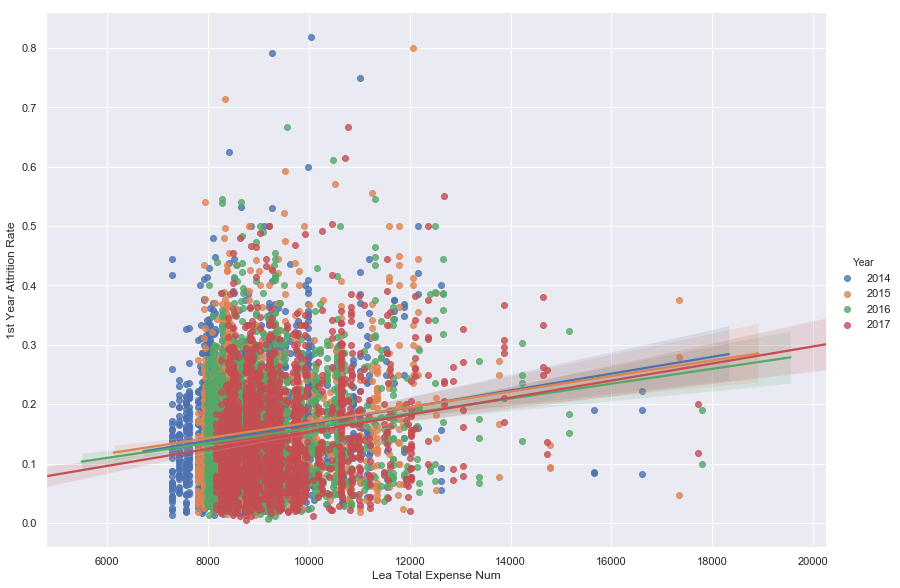

In [28]:
sns.lmplot(x="lea_total_expense_num", y="_1yr_tchr_trnovr_pct", hue="Year", data=schData,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('1st Year Attrition Rate')
plt.xlabel('Lea Total Expense Num')
plt.savefig('Figure2.png')

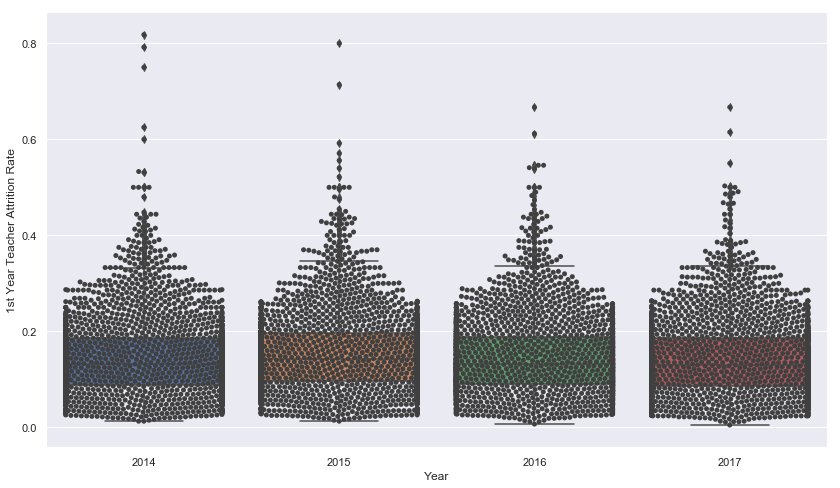

In [29]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData)
ax = sns.swarmplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData, color=".25")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Year')
plt.savefig('Figure3.png')

In [18]:
#schData.info(verbose=True)

## Feature Selection
* set max features we want to select

### Manually remove columns

* there columns is not what we are interested in, so we remove them manaually from data set

In [19]:
# manually remove the columns

ManualDropFeatures = ['st_1yr_tchr_trnovr_pct','lea_1yr_tchr_trnovr_pct','PacificIslandPct','PacificIslandMalePct','PacificIslandFemalePct','HispanicPct'
                      ,'BlackPct','AsianPct','IndianPct','WhitePct','TwoOrMorePct','TwoOrMoreMalePct','TwoOrMoreFemalePct'

                      ,'lea_supplies_expense_pct'
                      ,'lea_services_expense_pct','lea_salary_expense_pct','lea_total_expense_num','lea_benefits_expense_pct'                    
                     ]

schData = schData.drop(ManualDropFeatures,axis=1)
print('*********After: Removing fetures we are not interested in ******')
schData.info(verbose=False)
print ('\r\nFeatures Deleted: ', len(ManualDropFeatures))

*********After: Removing fetures we are not interested in ******
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9253 entries, 1 to 9755
Columns: 395 entries, (TCE) prepared returns Ct 100KLT200K to lea_salary
dtypes: float64(376), int64(19)
memory usage: 28.3 MB

Features Deleted:  18


## These features have big number of the weight in feature selection, trying to remove them and see if it will be better

In [20]:
schData = schData.drop(['Number of farm returns All','Number of farm returns 100KLT200K',
'Number of farm returns LT25K',
'Number of farm returns 25KLT50K',
'Number of farm returns 50KLT75K',
'Number of farm returns 75KLT100K',
'Number of farm returns GE200K'],axis=1)

## Transformation

In [21]:
# Get the X and y
y= schData['_1yr_tchr_trnovr_pct']
X = schData.drop(['_1yr_tchr_trnovr_pct'],axis=1)

In [22]:
# Transform

saved_cols = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)
#Save as data frames
X = pd.DataFrame(X)
X.columns = saved_cols


C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [23]:
# threthold for the feature selection
max_features =200
# backup the data set
schData_bak = schData
#schData = schData_bak

In [24]:
# Feature Selection 
X_fs = X
y_fs = y


## Pearson Correlation

In [25]:
# Pearson Correlation
feature_name = X_fs.columns.tolist()
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
        # replace NaN with 0
        cor_list = [0 if np.isnan(i) else i for i in cor_list]
        # feature name
        cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-max_features:]].columns.tolist()
        # feature selection? 0 for not select, 1 for select
        cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_fs, y_fs)
print(str(len(cor_feature)), 'selected features')
print(pd.DataFrame( cor_feature))

200 selected features
                                                     0
0                          ReadingGr3-8_pTarget_PctMet
1      Exceeds Expected Growth_TCHR_Student Growth_Pct
2    Does Not Meet Expected Growth_TCHR_Student Gro...
3                               SBE District_Northeast
4                                          pct_GCE_ALL
5    Domestic production activities deduction Amt 5...
6                                EOGReadingGr3_GLP_LEP
7                                    EOGGr3_CACR_Asian
8                                    EOGGr4_CACR_Asian
9                                   Reading  SPG Score
10                              EOGReadingGr3_CACR_LEP
11                                 EOGMathGr3_CACR_LEP
12                      school_type_txt_Regular School
13                             EOGScienceGr5&8_GLP_SWD
14                              stud_internet_comp_num
15                          EVAAS Growth Status_NotMet
16                                 EOCMathI

## Linear Reggesion RFE

In [26]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=max_features, step=10, verbose=5)
rfe_selector.fit(X_fs, y_fs)
rfe_support = rfe_selector.get_support()
rfe_feature = X_fs.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(pd.DataFrame(rfe_feature))

Fitting estimator with 387 features.
Fitting estimator with 377 features.
Fitting estimator with 367 features.
Fitting estimator with 357 features.
Fitting estimator with 347 features.
Fitting estimator with 337 features.
Fitting estimator with 327 features.
Fitting estimator with 317 features.
Fitting estimator with 307 features.
Fitting estimator with 297 features.
Fitting estimator with 287 features.
Fitting estimator with 277 features.
Fitting estimator with 267 features.
Fitting estimator with 257 features.
Fitting estimator with 247 features.
Fitting estimator with 237 features.
Fitting estimator with 227 features.
Fitting estimator with 217 features.
Fitting estimator with 207 features.
200 selected features
                                                     0
0                 (TCE) prepared returns Ct 100KLT200K
1                  (VITA) prepared returns Ct 25KLT50K
2                           0-3 Years_LEA_Exp_Pct_Prin
3                                              01_Size


## Linear Regression

In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression

Linear = LinearRegression()

Linear_selector = SelectFromModel(Linear, threshold='1.25*median', max_features=max_features)
Linear_selector.fit(X_fs, y_fs)
Linear_support = Linear_selector.get_support()
Linear_feature = X_fs.loc[:,Linear_support].columns.tolist()
print(str(len(Linear_feature)), 'selected features')
print(pd.DataFrame(Linear_feature))

160 selected features
                                                     0
0                   (TCE) prepared returns Ct 25KLT50K
1                  (VITA) prepared returns Ct 25KLT50K
2                           0-3 Years_LEA_Exp_Pct_Prin
3                                              00_Size
4                                              01_Size
5                                              03_Size
6                                              04_Size
7                                              05_Size
8                           10+ Years_LEA_Exp_Pct_Prin
9                          4-10 Years_LEA_Exp_Pct_Prin
10                    Accomplished_TCHR_Standard 1_Pct
11                    Accomplished_TCHR_Standard 2_Pct
12                    Accomplished_TCHR_Standard 3_Pct
13                    Accomplished_TCHR_Standard 5_Pct
14                     Add Medicare tax Amt 100KLT200K
15                   Add child tax credit Amt 25KLT50K
16                Alternative minimum tax A

## Lasso

In [28]:

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

from sklearn.linear_model import Ridge

LassoCV = LassoCV(cv = 5)

LassoCV_selector = SelectFromModel(LassoCV, threshold='1.25*median', max_features=max_features)
LassoCV_selector.fit(X_fs, y_fs)
LassoCV_support = LassoCV_selector.get_support()
LassoCV_feature = X_fs.loc[:,LassoCV_support].columns.tolist()
print(str(len(LassoCV_feature)), 'selected features')
print(pd.DataFrame(LassoCV_feature))

200 selected features
                                                     0
0                 (TCE) prepared returns Ct 100KLT200K
1                   (TCE) prepared returns Ct 25KLT50K
2                  (TCE) prepared returns Ct 75KLT100K
3                (VITA) prepared returns Ct 100KLT200K
4                  (VITA) prepared returns Ct 25KLT50K
5                  (VITA) prepared returns Ct 50KLT75K
6                           0-3 Years_LEA_Exp_Pct_Prin
7                                              00_Size
8                                              01_Size
9                                              02_Size
10                                             03_Size
11                                             04_Size
12                                             05_Size
13                          10+ Years_LEA_Exp_Pct_Prin
14                         4-10 Years_LEA_Exp_Pct_Prin
15                    Accomplished_TCHR_Standard 1_Pct
16                    Accomplished_TCHR_Sta

## Ridge Regression

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge

reg = Ridge()

reg_selector = SelectFromModel(reg, threshold='1.25*median', max_features=max_features)
reg_selector.fit(X_fs, y_fs)
reg_support = reg_selector.get_support()
reg_feature = X_fs.loc[:,reg_support].columns.tolist()
print(str(len(reg_feature)), 'selected features')
print(pd.DataFrame(reg_feature))

159 selected features
                                                     0
0                           0-3 Years_LEA_Exp_Pct_Prin
1                                              00_Size
2                                              01_Size
3                                              03_Size
4                                              04_Size
5                                              05_Size
6                           10+ Years_LEA_Exp_Pct_Prin
7                          4-10 Years_LEA_Exp_Pct_Prin
8                     Accomplished_TCHR_Standard 1_Pct
9                     Accomplished_TCHR_Standard 2_Pct
10                    Accomplished_TCHR_Standard 4_Pct
11                    Accomplished_TCHR_Standard 5_Pct
12                   Add child tax credit Amt 25KLT50K
13                Alternative minimum tax Amt 50KLT75K
14               Alternative minimum tax Amt 75KLT100K
15                 Alternative minimum tax Ct 50KLT75K
16                        Attrtion_Reason_O

## Elastic Net Regression

In [30]:
from sklearn.linear_model import ElasticNet

ELN = ElasticNet()

ELN_selector = SelectFromModel(ELN, threshold='1.25*median', max_features=max_features)
ELN_selector.fit(X_fs, y_fs)
ELN_support = ELN_selector.get_support()
ELN_feature = X_fs.loc[:,ELN_support].columns.tolist()
print(str(len(ELN_feature)), 'selected features')
print(pd.DataFrame(ELN_feature))


200 selected features
                                                     0
0                 (TCE) prepared returns Ct 100KLT200K
1                   (TCE) prepared returns Ct 25KLT50K
2                  (TCE) prepared returns Ct 75KLT100K
3                (VITA) prepared returns Ct 100KLT200K
4                  (VITA) prepared returns Ct 25KLT50K
5                  (VITA) prepared returns Ct 50KLT75K
6                           0-3 Years_LEA_Exp_Pct_Prin
7                                              00_Size
8                                              01_Size
9                                              02_Size
10                                             03_Size
11                                             04_Size
12                                             05_Size
13                          10+ Years_LEA_Exp_Pct_Prin
14                         4-10 Years_LEA_Exp_Pct_Prin
15                    Accomplished_TCHR_Standard 1_Pct
16                    Accomplished_TCHR_Sta

In [31]:
## Summary
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name
                                     , 'Pearson':cor_support
                                     , 'Linear Regression':Linear_support
                                     , 'RFE':rfe_support
                                     , 'Lasso':LassoCV_support
                                     ,'Ridge':reg_support
                                     , 'Elastic Net':ELN_support
                                     
                                    })
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] ,
ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

,Feature,Pearson,Linear Regression,RFE,Lasso,Ridge,Elastic Net,Total
1,EOGMathGr5_CACR_Hispanic,True,True,True,True,True,True,6
2,EOGMathGr3-8_CACR_EDS,True,True,True,True,True,True,6
3,EOGMathGr3-8_CACR_AIG,True,True,True,True,True,True,6
4,EOGGr4_CACR_Hispanic,True,True,True,True,True,True,6
5,EOGGr4_CACR_All,True,True,True,True,True,True,6
6,EOGGr3_CACR_SWD,True,True,True,True,True,True,6
7,EOGGr3_CACR_All,True,True,True,True,True,True,6
8,EOG/EOCSubjects_CACR_TwoorMoreRaces,True,True,True,True,True,True,6
9,EOG/EOCSubjects_CACR_Hispanic,True,True,True,True,True,True,6
10,EOG/EOCSubjects_CACR_EDS,True,True,True,True,True,True,6


In [32]:
# export feature selection to csv file
feature_selection_df.to_csv('Feature_Selection_Results.csv', sep=',', index=False)

In [33]:
feature_to_remove = feature_selection_df[feature_selection_df['Total']<3]['Feature']
X = X.drop(feature_to_remove, axis=1)

#feature_to_remove
print ('\r\nFeatures Deleted: ', len(feature_to_remove))


Features Deleted:  160


## RFE Feature Importance

In [34]:
# %%time

# df2_vif = pd.DataFrame()
# df2_vif["VIF Factor"] = [vif(X.values, i) for i in range(X.shape[1])]
# df2_vif["ABSVIFFactor"] = abs(df2_vif["VIF Factor"])
# df2_vif["features"] = X.columns
# df2_vif["indexes"] = range(0, len(X.columns))

In [35]:
# df2_vif = df2_vif.sort_values('ABSVIFFactor', ascending=True)
# df2_vif.to_csv('VIF_Result_ML.csv', sep=',', index=False)

In [36]:
# %%time



# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#     test_size=0.3,random_state =1 )

# #print("RFE CV Linear Regression 1st Pass")
# rfecvEstimator = LinearRegression()

# parameters = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

# #Create a grid search object  

# grid = GridSearchCV(estimator=rfecvEstimator
#                    #, n_jobs=8 # jobs to run in parallel
#                    #, verbose=0 # low verbosity
#                    , param_grid=parameters
#                   )

# #Perform hyperparameter search to find the best combination of parameters for our data using RFECV
# grid.fit(X_train, y_train)
# print("r2 / variance : ", grid.best_score_)
# print("Residual sum of squares: %.2f"
#               % np.mean((grid.predict(X_test) - y_test) ** 2))

In [37]:

#Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

In [38]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score 
#from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_scorer 

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
# revised from - https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
# still not working
def mape(y_actual, y_predicted): 
    mask = y_actual != 0           
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100
# Credit: https://alex.miller.im/posts/linear-model-custom-loss-function-regularization-python/
def mean_absolute_percentage_error(y_true, y_pred, sample_weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    if np.any(y_true==0):
        print("Found zeroes in y_true. MAPE undefined. Removing from set...")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        if type(sample_weights) != type(None):
            sample_weights = np.array(sample_weights)
            sample_weights = np.delete(sample_weights, idx)
        
    if type(sample_weights) == type(None):
        return(np.mean(np.abs((y_true - y_pred) / y_true)))
    else:
        sample_weights = np.array(sample_weights)
        assert len(sample_weights) == len(y_true)
        return(100/sum(sample_weights)*np.dot(
                sample_weights, (np.abs((y_true - y_pred) / y_true))
        ))
    
#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(score_func=mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
#mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
r2_scorer = make_scorer(score_func=r2_score, greater_is_better=True) 

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'MSE':  mse_scorer, 
                'RMSE': rmse_scorer,
                #'MAPE': mape_scorer,
                'R2': r2_scorer       
               } 

In [39]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MSE'] = scores['test_MSE'] * -1
    #scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

     #print mean MAE for all folds 
    mseAvg = scores['test_MSE'].mean()
    print_str = "The average MSE for all cv folds is: \t\t\t {mseAvg:.5}"
    print(print_str.format(mseAvg=mseAvg))
    
    #print mean test_MAPE for all folds
#     scores['test_MAPE'] = scores['test_MAPE']
#     mape_avg = scores['test_MAPE'].mean()
#     print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
#     print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')
    
    #print mean R-squared for all folds 
    R2avg = scores['test_R2'].mean()
    print_str = "The average R-Squared for all cv folds is: \t\t {R2avg:.5}"
    print(print_str.format(R2avg=R2avg))
    print('*********************************************************')


    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MSE'] = scores['test_MSE']
   # scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['R2'] = scores['test_R2']
    return scoresResults


In [40]:
%%time


print("RFE CV Linear Regression 1st Pass")
rfecvEstimator = LinearRegression()

parameters = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]
             }

#Create a grid search object  
#from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
                   , n_jobs=8 # jobs to run in parallel
                  , verbose=0 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   )

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(X, y)

#Use the best parameters for our RFECV Linear Regression object
rfecvLinearEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvLinearEst, step=1, cv=cv,  verbose=1)
X_BestFeatures = rfecv.fit_transform(X, y)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

print("Linear Regression Second Pass")
#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LinearRegression())

#Define a range of hyper parameters for grid search
parameters = { 'linearregression__fit_intercept':[True,False], 'linearregression__normalize':[True,False]
              , 'linearregression__copy_X':[True, False]
              , 'linearregression__n_jobs':[None]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(estimator=pipe, param_grid=parameters, cv=cv)

#Use the best features from recursive feature elimination during the grid search
grid.fit(X, y)


RFE CV Linear Regression 1st Pass
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitt

Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
F

Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
F

Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
F

Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
F

Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
F

Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
F

Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
F

Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
F

Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
F

Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Ranking [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  1  1 12  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 11  1  9  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 14  1  1  1  1  4  1  1  1
  1  1  5  1  1  1  1  2  7  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  8  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 

In [41]:
#Print the parameterization of the best estimator
regEstimator = grid.best_estimator_

RFE_Results = EvaluateRegressionEstimator(grid.best_estimator_, X_BestFeatures, y, cv)

The average MAE for all cv folds is: 			 0.05038
The average MSE for all cv folds is: 			 0.004387
The average RMSE for all cv folds is: 			 0.066218
*********************************************************
The average R-Squared for all cv folds is: 		 0.3589
*********************************************************
Cross Validation Fold Mean Error Scores


In [42]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = regEstimator.named_steps['linearregression'].coef_.ravel()#[rfecv.get_support(indices=True)]
feature_names = X.columns#.values[rfecv.get_support(indices=True)]
#print(weights)

In [43]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
#weights = grid.best_estimator_.named_steps['linearregression'].coef_.ravel()
#feature_names = X.columns#.values[rfecv.get_support(indices=True)]

linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights,
                                 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

#Print out all the missing value rows
pd.set_option('display.max_rows', 1000)

#linreg_ft_imp_df = linreg_ft_imp_df[linreg_ft_imp_df.feature_names != 'SchoolYear']

model_features = len(linreg_ft_imp_df.index)
print('Total Model Features: ' + str(model_features))

#Print all of the features selected by the model 
linreg_ft_imp_df


Total Model Features: 227


,feature_names,weights,absolute_weights
222,tchyrs_11plus_pct,0.241089,0.241089
221,tchyrs_0thru3_pct,0.233813,0.233813
223,tchyrs_4thru10_pct,0.162577,0.162577
215,st_avg_daily_attend_pct,0.108074,0.108074
3,0-3 Years_LEA_Exp_Pct_Prin,-0.095691,0.095691
11,4-10 Years_LEA_Exp_Pct_Prin,-0.088591,0.088591
219,st_tchyrs_11plus_pct,-0.066053,0.066053
10,10+ Years_LEA_Exp_Pct_Prin,-0.059991,0.059991
206,lea_tchyrs_11plus_pct,0.050925,0.050925
205,lea_tchyrs_0thru3_pct,0.048015,0.048015


Total Model Features: 100


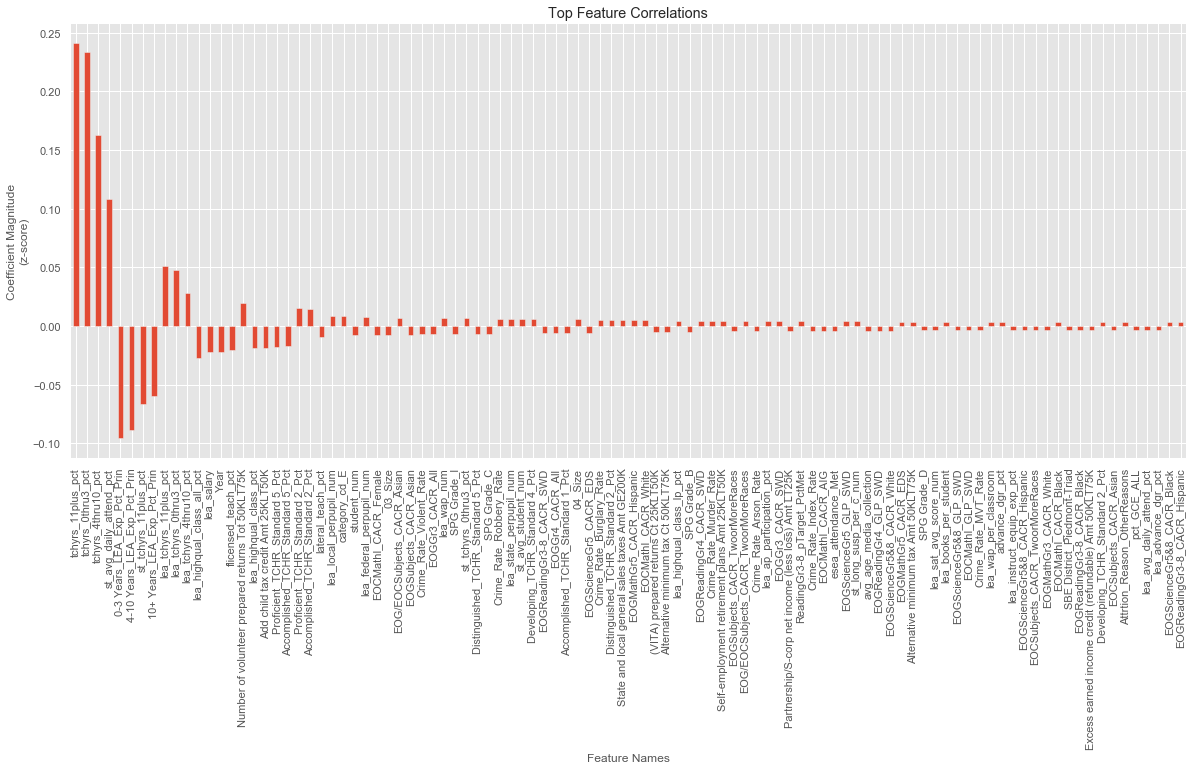

In [44]:
#Get the top 75 coefficients
wt_plt_df = linreg_ft_imp_df.head(100)

model_features = len(wt_plt_df.index)
print('Total Model Features: ' + str(model_features))

# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [45]:
# export feature selection to csv file
linreg_ft_imp_df.to_csv('RFE_Feature_Importance_Results.csv', sep=',', index=False)

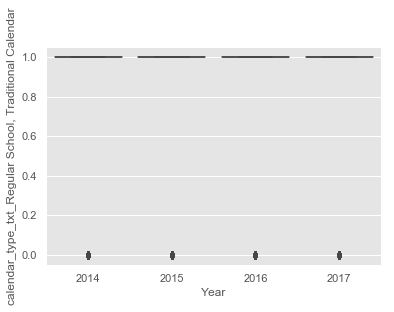

In [46]:
ax = sns.boxplot(x="Year", y="calendar_type_txt_Regular School, Traditional Calendar", data=schData)

## Several Features not making sense

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [47]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state =1 )

## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [48]:
# it may not make sense to use MAPE in our project based on below articles:
# http://www.catchbull.com/catchblogs/why-mape-doesnt-work


## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

## Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with graduation rate predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [49]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [50]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False),'normalize': (True, False),}

#Create a grid search object using the  
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [51]:
#Print the parameterization of the best estimator
regEstimator = regGridSearch.best_estimator_
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
CappedLinear_Results = EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.050887
The average MSE for all cv folds is: 			 0.0045288
The average RMSE for all cv folds is: 			 0.067265
*********************************************************
The average R-Squared for all cv folds is: 		 0.33632
*********************************************************
Cross Validation Fold Mean Error Scores


In [52]:
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_train, y_train)
yhat = regEstimator.predict(X_test)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.4442771110342545


## Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [53]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
reg = SVR()

#Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
costs = [0.001, 0.1]
defGamma = 1 / X.shape[1]  #This is the default value for the gamma parameter
gammas = [defGamma, 0.1]
kernels = ['rbf','linear']
parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   56.6s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:  3.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'C': [0.001, 0.1], 'gamma': [0.004405286343612335, 0.1], 'kernel': ['rbf', 'linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [54]:
#Display the best estimator parameters
regGridSearch.best_estimator_

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.004405286343612335, kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
# from sklearn.svm import SVR

#Create a regression estimator with best parameters for cross validation
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
SVR_Results=EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.052817
The average MSE for all cv folds is: 			 0.0046812
The average RMSE for all cv folds is: 			 0.068388
*********************************************************
The average R-Squared for all cv folds is: 		 0.31418
*********************************************************
Cross Validation Fold Mean Error Scores


In [56]:
#Do we predict graduation rates greater than 100%?
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

regEstimator.fit(X_train, y_train)
yhat = regEstimator.predict(X_test)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.43626632721960024


## Graduation Rate - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [57]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    4.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [58]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

In [59]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Lasso_Results = EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.062496
The average MSE for all cv folds is: 			 0.0068469
The average RMSE for all cv folds is: 			 0.082683
*********************************************************
The average R-Squared for all cv folds is: 		 -0.00059349
*********************************************************
Cross Validation Fold Mean Error Scores


In [60]:
#Do we predict graduation rates greater than 100%?
# regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
#    normalize=True, positive=False, precompute=True, random_state=0,
#    selection='cyclic', tol=0.0001, warm_start=True)
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_train, y_train)
yhat = regEstimator.predict(X_test)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.14858020688590398


## Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [61]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 360 out of 360 | elapsed:  3.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [62]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, random_state=0, solver='svd', tol=0.0001)

In [63]:
%%time
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Ridge_Results = EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.050738
The average MSE for all cv folds is: 			 0.0044956
The average RMSE for all cv folds is: 			 0.067019
*********************************************************
The average R-Squared for all cv folds is: 		 0.34127
*********************************************************
Cross Validation Fold Mean Error Scores
Wall time: 2.18 s


In [64]:
#Do we predict graduation rates greater than 100%?
# regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
#    normalize=True, random_state=0, solver='saga', tol=0.0001)
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_train, y_train)
yhat = regEstimator.predict(X_test)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.423774526460713


## Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [65]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
elasticNetGridSearch = GridSearchCV(estimator=elasticNet
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
elasticNetGridSearch.fit(X, y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   16.6s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:   20.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'alpha': [0.001, 0.1, 1, 10], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [66]:
#Display the best estimator parameters
elasticNetGridSearch.best_estimator_

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.001,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='random', tol=0.0001, warm_start=True)

In [67]:
#Create a regression estimator with best parameters for cross validation
elasticNetEstimator = elasticNetGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
elastic_Results = EvaluateRegressionEstimator(elasticNetEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.054844
The average MSE for all cv folds is: 			 0.0052665
The average RMSE for all cv folds is: 			 0.072521
*********************************************************
The average R-Squared for all cv folds is: 		 0.23
*********************************************************
Cross Validation Fold Mean Error Scores


In [68]:
#Do we predict graduation rates greater than 100%?
elasticNetEstimator =  elasticNetGridSearch.best_estimator_

elasticNetEstimator.fit(X_train, y_train)
yhat = elasticNetEstimator.predict(X_test)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.28293125772526695


## XGBoost

In [69]:
# credit: https://www.kaggle.com/mburakergenc/predictions-with-xgboost-and-linear-regression


In [70]:
regr = LinearRegression()

In [71]:
 #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state =1 )

In [72]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [73]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

C:\Users\yubin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.75)

In [74]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

-0.5552775036439177
